In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import fsspec
import cftime
from dask import optimize
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

/var/folders/7y/lr_w90f56s35gmw3l6ghkz_w0000gn/T/ipykernel_21082/3290393657.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [3]:
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2' & experiment_id =='historical'")
ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[-1]), consolidated=True)
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])

In [4]:
# df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2' & variable_id == 'tas'  & institution_id == 'NCAR'")
df_prw_ncar_his = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'prw' & institution_id == 'NCAR' & experiment_id == 'historical'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_his = df_prw_ncar_his.zstore.values[-1]
print(zstore_his)

# create a mutable-mapping-style interface to the store
mapper_his = fsspec.get_mapper(zstore_his)

# open it using xarray and zarr
ds_prw_his = xr.open_zarr(mapper_his, consolidated=True)
display(ds_prw_his)


# date_threshold = cftime.DatetimeNoLeap(1550, 1, 1)
# ds_tas_his_plt = ds_tas_his.where(ds_tas_his.time > date_threshold, drop=True)
# # weighted product
# tas_timeseries_his = (ds_tas_his_plt.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
# # convert to np array
# array_tas_ts = np.array(tas_timeseries_his)
# # plt.plot(array_tas_ts)
# # plt.show()
# year_tas_ts = np.mean(array_tas_ts.reshape(1980//12, 12), axis=1)
# # plt.plot(year_tas_ts)
# # plt.show()

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/prw/gn/v20190514/


<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    prw        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    variable_id:            prw
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/8e2bf5bf-2173-4813-92b0-c53c5589979c...
    version_id:             v20190514

## The coordinate of equator, Singapore, and Brazil are defined here

In [5]:
lats = np.array(ds_prw_his.lat)

n = len(lats)
equator_lat = lats[n//2]
equator_lat

0.47120418848167844

## Latitude range

In [22]:
lat_range = ds_prw_his.lat.sel(lat=slice(-20, 20))

In [6]:
singapore_coor = [lats[n//2+1], 103.75]
brazil_coor = [lats[n//2+1], 300]
print(singapore_coor, brazil_coor)

[1.4136125654450211, 103.75] [1.4136125654450211, 300]


In [7]:
# ds_prw_his.prw.sel(time='1950-07', lat=equator_lat).squeeze().plot()
# ds_prw_his.prw.sel(lat = equator_lat, time='1950-07').squeeze().plot()

In [23]:
(ds_prw_his.prw * ds_area.areacella).sel(lat = lat_range)

<xarray.DataArray (time: 1980, lat: 42, lon: 288)>
dask.array<getitem, shape=(1980, 42, 288), dtype=float32, chunksize=(600, 42, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -19.32 -18.38 -17.43 -16.49 ... 17.43 18.38 19.32
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

## The timeseries of Water Vapor Path for equator, singapore, and Brazil are defined here

In [31]:
eqt_area = ds_area.areacella.sel(lat = lat_range).sum(dim=['lon', 'lat'])

eqt_prw_ts = (ds_prw_his.prw * ds_area.areacella).sel(lat=lat_range).sum(dim=['lat', 'lon']) / eqt_area
# convert to np array
array_eqt_prw_ts = np.array(eqt_prw_ts)

time = np.arange(1850, 2015, 1/12)

In [10]:
array_sgp_prw_ts = np.array(ds_prw_his.prw.sel(lat=singapore_coor[0], lon=singapore_coor[1]))
array_bzl_prw_ts = np.array(ds_prw_his.prw.sel(lat=brazil_coor[0], lon=brazil_coor[1]))

In [11]:
len(array_sgp_prw_ts)

1980

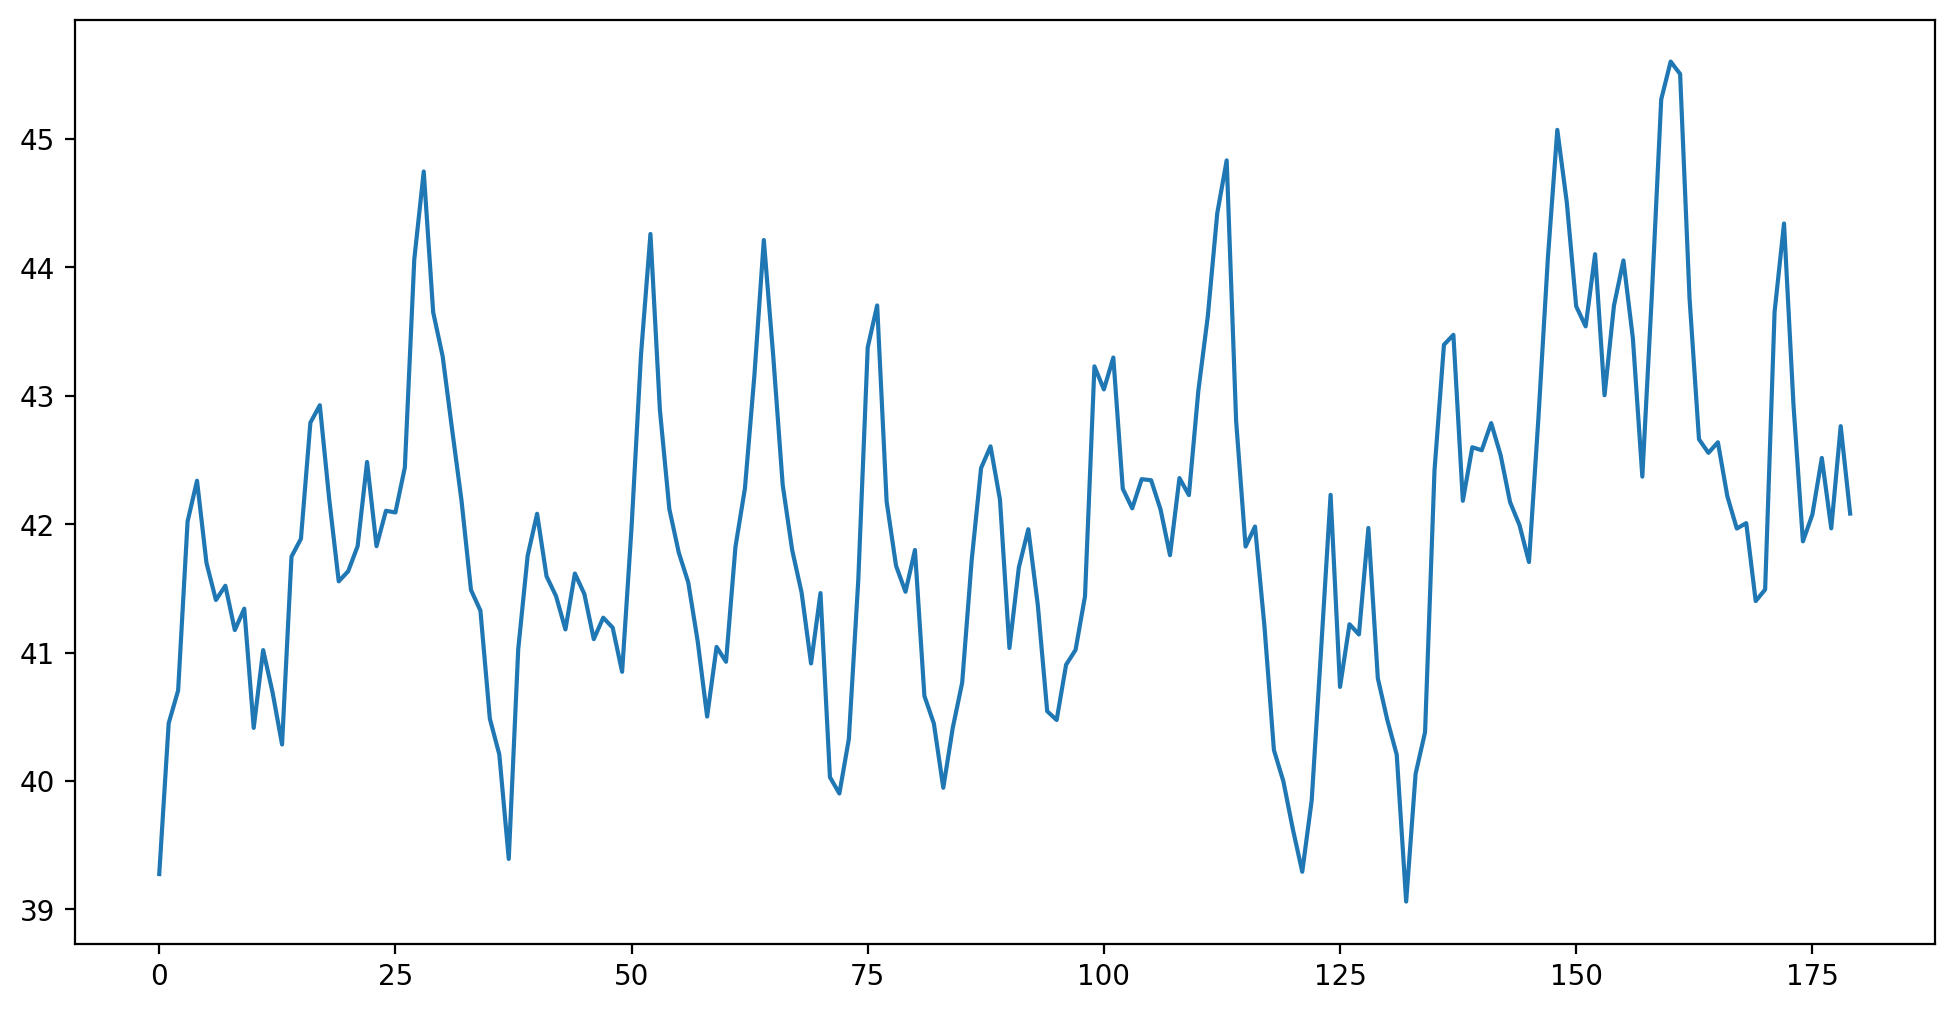

In [32]:
plt.plot(array_eqt_prw_ts[1800:2000])
plt.show()

## The timeseries of Surface Temperature for equator, singapore, and Brazil are defined here

In [33]:
df_tas_ncar_his = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'tas' & institution_id == 'NCAR' & experiment_id == 'historical'")
zstore_his = df_tas_ncar_his.zstore.values[-1]
print(zstore_his)
mapper_his = fsspec.get_mapper(zstore_his)
ds_tas_his = xr.open_zarr(mapper_his, consolidated=True)
# date_threshold = cftime.DatetimeNoLeap(1550, 1, 1)
# ds_tas_his_plt = ds_tas_his.where(ds_tas_his.time > date_threshold, drop=True)
eqt_tas_ts = (ds_tas_his.tas * ds_area.areacella).sel(lat=lat_range).sum(dim=['lon', 'lat']) / eqt_area

array_eqt_tas_ts = np.array(eqt_tas_ts)
array_sgp_tas_ts = np.array(ds_tas_his.tas.sel(lat=singapore_coor[0], lon=singapore_coor[1]))
array_bzl_tas_ts = np.array(ds_tas_his.tas.sel(lat=brazil_coor[0], lon=brazil_coor[1]))

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/tas/gn/v20190514/


### Want to estimate $TPW \propto \exp(\alpha + \beta * \Delta T)$. This is the simplified Clausius-Clapeyron formula in Marshall & Plumb

## The alpha and beta in the output are in this formula: $TPW = \exp(\alpha) \cdot \exp(\beta T)$

## Linear Regression for equitorial region

{'fit_intercept': True, 'normalize': 'deprecated', 'copy_X': True, 'n_jobs': None, 'positive': False, 'n_features_in_': 1, 'coef_': array([0.05817519], dtype=float32), 'rank_': 1, 'singular_': array([20.553722], dtype=float32), 'intercept_': -13.69482}
alpha: 1.1282752439001342e-06
beta: 0.058175187557935715


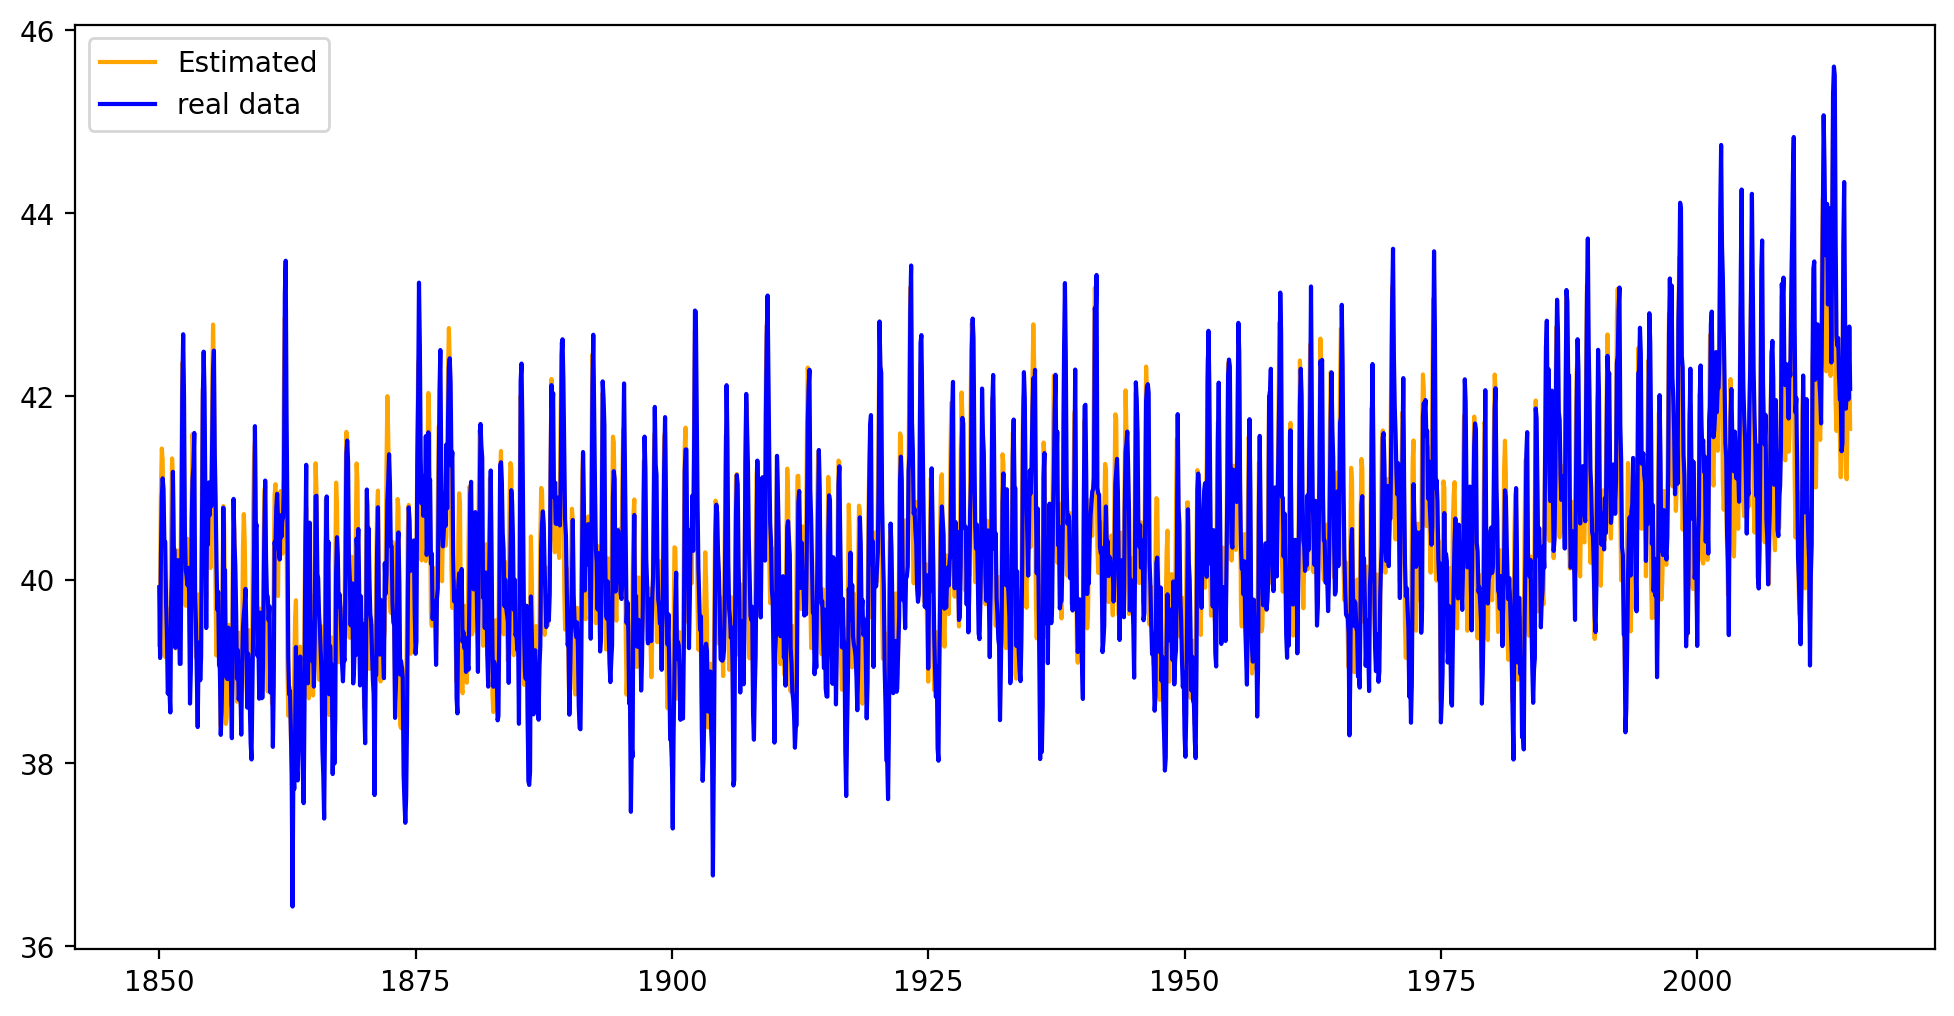

In [35]:
ln_TPW = np.log(array_eqt_prw_ts)
X_tas_ts = array_eqt_tas_ts.reshape(-1, 1)

LR_model = LinearRegression()
LR_model.fit(X_tas_ts, ln_TPW)

print(vars(LR_model))

beta = LR_model.coef_[0]  # Slope is negative feedback parameter
alpha = LR_model.intercept_  # Intercept is radiative forcing

print(f"alpha: {np.exp(alpha)}")
print(f"beta: {beta}")

i_left, i_right = 0, 2000
estimated_TPW_ts = np.exp(alpha + beta * array_eqt_tas_ts)
plt.plot(time[i_left : i_right], estimated_TPW_ts[i_left : i_right], label="Estimated", color="orange")
plt.plot(time[i_left : i_right], array_eqt_prw_ts[i_left : i_right], label="real data", color="blue")
plt.legend()
plt.show()

## Linear Regression for Singapore

In [16]:
ln_TPW = np.log(array_sgp_prw_ts)
X_tas_ts = array_sgp_tas_ts.reshape(-1, 1)

LR_model = LinearRegression()
LR_model.fit(X_tas_ts, ln_TPW)

print(vars(LR_model))

beta = LR_model.coef_[0]  # Slope is negative feedback parameter
alpha = LR_model.intercept_  # Intercept is radiative forcing

print(f"e^alpha: {np.exp(alpha)}")
print(f"beta: {beta}")
# i_left, i_right = 800, 1000
# estimated_TPW_ts = np.exp(alpha + beta * array_sgp_tas_ts)
# plt.plot(estimated_TPW_ts, label="Estimated", color="orange")
# plt.plot(array_sgp_prw_ts, label="real data", color="blue")
# plt.legend()
# plt.show()

{'fit_intercept': True, 'normalize': 'deprecated', 'copy_X': True, 'n_jobs': None, 'positive': False, 'n_features_in_': 1, 'coef_': array([0.05867154], dtype=float32), 'rank_': 1, 'singular_': array([25.743486], dtype=float32), 'intercept_': -13.65763}
e^alpha: 1.1710263834174839e-06
beta: 0.05867153778672218


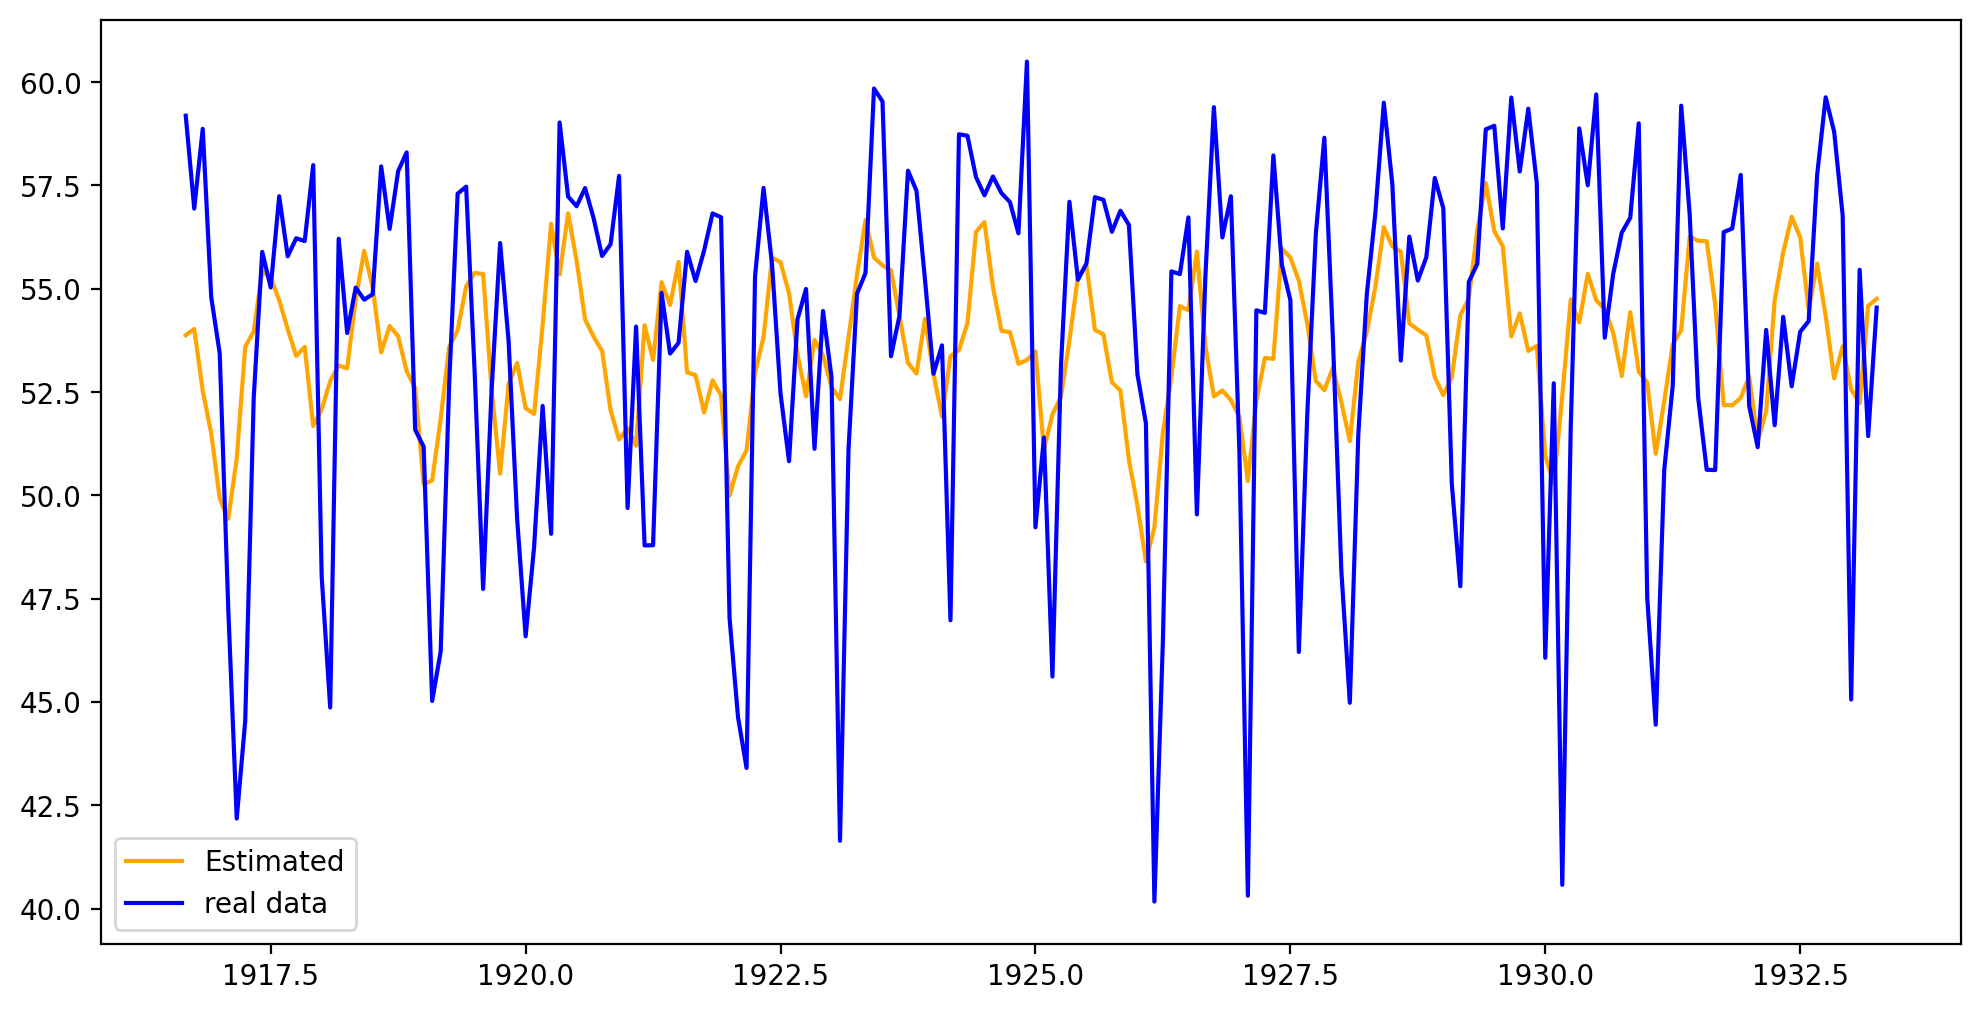

In [17]:
i_left, i_right = 800, 1000
estimated_TPW_ts = np.exp(alpha + beta * array_sgp_tas_ts)
plt.plot(time[i_left : i_right], estimated_TPW_ts[i_left : i_right], label="Estimated", color="orange")
plt.plot(time[i_left : i_right], array_sgp_prw_ts[i_left : i_right], label="real data", color="blue")
plt.legend()
plt.show()

## Linear Regression for Brazil

In [18]:
ln_TPW = np.log(array_bzl_prw_ts)
X_tas_ts = array_bzl_tas_ts.reshape(-1, 1)

LR_model = LinearRegression()
LR_model.fit(X_tas_ts, ln_TPW)

print(vars(LR_model))

beta = LR_model.coef_[0]  # Slope is negative feedback parameter
alpha = LR_model.intercept_  # Intercept is radiative forcing

print(f"e^ alpha: {np.exp(alpha)}")
print(f"beta: {beta}")

estimated_TPW_ts = np.exp(alpha + beta * array_bzl_tas_ts)


{'fit_intercept': True, 'normalize': 'deprecated', 'copy_X': True, 'n_jobs': None, 'positive': False, 'n_features_in_': 1, 'coef_': array([-0.04038654], dtype=float32), 'rank_': 1, 'singular_': array([41.776695], dtype=float32), 'intercept_': 15.960973}
e^ alpha: 8545991.0
beta: -0.040386542677879333


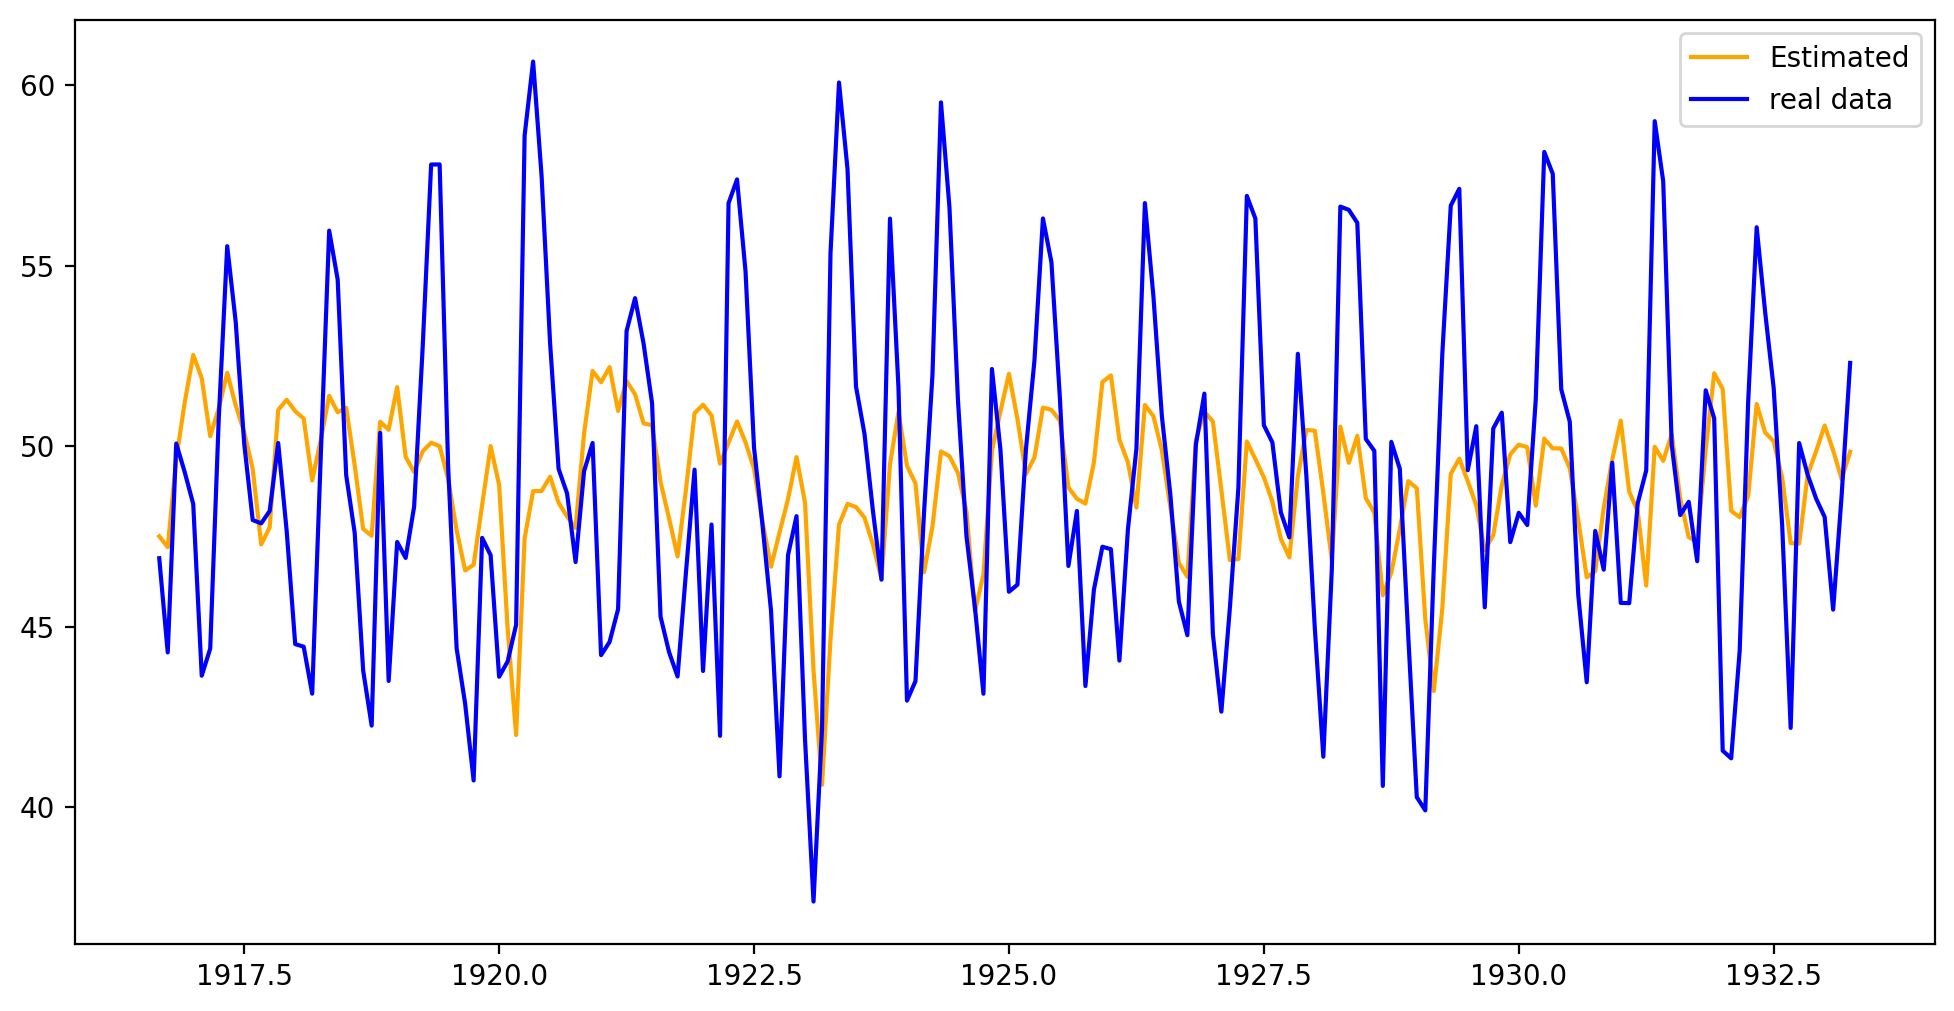

In [19]:

# The interval, from 0 to 1980
i_left, i_right = 800, 1000
plt.plot(time[i_left : i_right], estimated_TPW_ts[i_left : i_right], label="Estimated", color="orange")
plt.plot(time[i_left : i_right], array_bzl_prw_ts[i_left : i_right], label="real data", color="blue")
plt.legend()
plt.show()